In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.time_series import *
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.tsa.deterministic import Fourier

# Load data
df = pd.read_csv('hourly_csv\export-jsps016-1h.csv')
df["timestamp"] = pd.to_datetime(df["timestamp"], format="mixed")
df.set_index("timestamp", inplace=True)


# Drop unnecessary columns
df.drop(columns=["timezone", "Unnamed: 0","location"], inplace=True, errors="ignore")

# Resample to hourly and fill missing values

# Remove outliers using IQR
Q1 = df["pm_2_5"].quantile(0.25)
Q3 = df["pm_2_5"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["pm_2_5"] >= Q1 - 1.5 * IQR) & (df["pm_2_5"] <= Q3 + 1.5 * IQR)]

Q1t = df["temperature"].quantile(0.25)
Q3t = df["temperature"].quantile(0.75)
IQRt = Q3t - Q1t
df = df[(df["temperature"] >= Q1t - 1.5 * IQRt) & (df["temperature"] <= Q3t + 1.5 * IQRt)]

Q1h = df["humidity"].quantile(0.25)
Q3h = df["humidity"].quantile(0.75)
IQRh = Q3h - Q1h
df = df[(df["humidity"] >= Q1h - 1.5 * IQRh) & (df["humidity"] <= Q3h + 1.5 * IQRh)]
print(df)

# Q1h = df["pm_10"].quantile(0.25)
# Q3h = df["pm_10"].quantile(0.75)
# IQRh = Q3h - Q1h
# df = df[(df["pm_10"] >= Q1h - 1.5 * IQRh) & (df["pm_10"] <= Q3h + 1.5 * IQRh)]
# print(df)


df.interpolate(method="linear", inplace=True)

df = df.resample("D").mean().fillna(method="ffill")

# ✅ ปรับขนาดข้อมูลเป็น 4 ช่วงต่อวัน (ทุก 6 ชั่วโมง)
df = df.resample("D").mean()

# # ✅ Fourier Terms (Weekly Seasonality) สำหรับ 4 ช่วงต่อวัน
# fourier = Fourier(
#     period=7, order=2
# )  # Weekly seasonality with lower order (4 periods/day × 7 days)
# fourier_features = fourier.in_sample(df.index)
# df = pd.concat([df, fourier_features], axis=1)
# df.dropna(inplace=True)

# ✅ เพิ่ม Lag Features หลายระดับ (Short-Term & Long-Term) สำหรับ 4 ช่วงต่อวัน
for lag in [
    7 +1,
    7 + 3,
    7 + 7,
    7 + 14,
]:  # 1 วัน, 2 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_lag{lag}"] = df["pm_2_5"].shift(lag)
    # df[f"pm_10_lag{lag}"] = df["pm_10"].shift(lag)
    df[f"humidity_lag{lag}"] = df["humidity"].shift(lag)
    df[f"temperature_lag{lag}"] = df["temperature"].shift(lag)

# ✅ เพิ่ม Rolling Mean และ Rolling Std หลายระดับ
for window in [2, 3, 5,7,14]:  # 1 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_rollmean{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"pm_2_5_rollstd{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).std()
    )
    # df[f"pm_10_rollmean{window}"] = (
    #     df["pm_10"].shift(7).rolling(window=window, min_periods=1).mean()
    # )
    # df[f"pm_10_rollstd{window}"] = (
    #     df["pm_10"].shift(7).rolling(window=window, min_periods=1).std()
    # )
    df[f"humidity_rollmean{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"humidity_rollstd{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).std()
    )
    df[f"temperature_rollmean{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"temperature_rollstd{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).std()
    )

df = df.drop(columns=["temperature","humidity","pm_2_5_sp"])
# Keep only the last 1 year of data
one_year_ago = df.index.max() - pd.DateOffset(years=2)
df = df[df.index >= one_year_ago]
df = df.asfreq("D").fillna(method="bfill")  # เติมข้อมูลก่อนแบ่ง



# แบ่งข้อมูลสำหรับฝึกและทดสอบ (7 วัน = 28 ช่วง)
train = df.iloc[:-7]  # แบ่ง train
test = df.iloc[-7:]  # แบ่ง test

# ✅ เลือกเฉพาะฟีเจอร์ที่สำคัญ
selected_features = ["pm_2_5"] + [col for col in df.columns if col != "pm_2_5"]
train = train[selected_features]
test = test[selected_features]

                          humidity     pm_2_5  pm_2_5_sp  temperature
timestamp                                                            
2022-02-21 15:00:00.000  43.331457   8.857143   8.857143    34.107143
2022-02-21 16:00:00.000  45.372367   8.700000   8.700000    33.922000
2022-02-21 17:00:00.000  50.097468  15.677419  15.677419    32.933871
2022-02-21 18:00:00.000  54.722055  24.965517  25.310345    31.566207
2022-02-21 19:00:00.000  61.128573  27.032258  27.967742    29.828000
...                            ...        ...        ...          ...
2025-02-11 08:00:00.000  92.475335  44.925000  58.983333    24.632089
2025-02-11 09:00:00.000  85.673192  42.184874  56.176471    26.692493
2025-02-11 10:00:00.000  77.900921  21.575000  21.625000    28.398407
2025-02-11 11:00:00.000  69.598026  18.235294  18.235294    30.125741
2025-02-11 11:12:51.379  65.465030  17.653846  17.653846    31.040777

[23077 rows x 4 columns]


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode characters in position 282-299: character maps to <undefined>
Call stack:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\termproject1-2_cleandata\venv

In [24]:
print(df)

               pm_2_5  pm_2_5_lag8  humidity_lag8  temperature_lag8  \
timestamp                                                             
2023-02-11   0.343356     0.260938      89.837591         26.346231   
2023-02-12   0.571362     0.471088      74.389187         28.645535   
2023-02-13   0.631156     0.377255      71.453954         28.744330   
2023-02-14   0.770396     0.373299      71.491088         28.879505   
2023-02-15   0.489403     0.661045      69.379781         29.103275   
...               ...          ...            ...               ...   
2025-02-07  23.870686    17.610088      73.220795         26.922285   
2025-02-08  21.868438    27.211724      75.662957         26.435498   
2025-02-09  19.808958    34.580033      77.260462         26.688551   
2025-02-10  26.507221    35.374209      76.631609         26.565365   
2025-02-11  31.285423    25.355150      78.695010         26.480207   

            pm_2_5_lag10  humidity_lag10  temperature_lag10  pm_2_5_lag14  \

In [3]:


# ✅ เพิ่ม fold เป็น 5 เพื่อให้โมเดล Generalize ขึ้น
experiment = setup(
    data=train,
    target="pm_2_5",
    session_id=123,
    use_gpu=True,
    fh=7,  # Forecast horizon = 7 days (28 periods)
    fold=20,
    fold_strategy="sliding",
    seasonal_period=7

)
test.index = test.index.to_period("D")

# ✅ ลองโมเดล ARIMA ก่อน
arima_model = experiment.create_model('arima', order=(1, 0, 1), seasonal_order=(0, 0, 1, 7))
# arima_model = experiment.tune_model(arima_model,optimize="SMAPE",n_iter = 20)
final_arima = experiment.finalize_model(arima_model)

# Predict using the finalized model
X_forecast = test.drop(columns=["pm_2_5"])

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(725, 43)"
5,Transformed data shape,"(725, 43)"
6,Transformed train set shape,"(718, 43)"
7,Transformed test set shape,"(7, 43)"
8,Rows with missing values,0.0%
9,Fold Generator,SlidingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-09-10,0.6686,0.5790,5.6991,6.5535,0.8496,0.5386,-1.6103
1,2024-09-17,0.3189,0.2648,2.7391,3.0022,0.3561,0.3352,0.4505
2,2024-09-24,0.6673,0.5428,5.7716,6.1681,0.3913,0.4308,-0.8825
3,2024-10-01,0.3691,0.3256,3.2204,3.7128,0.3362,0.2686,-2.8688
4,2024-10-08,0.4026,0.3417,3.5419,3.9057,0.2167,0.2315,-0.4274
5,2024-10-15,0.5037,0.4843,4.4646,5.5458,0.4392,0.3215,-1.5014
6,2024-10-22,0.3214,0.2872,2.8676,3.2940,0.2044,0.1780,-0.0764
7,2024-10-29,0.5051,0.4679,4.4210,5.2602,0.3802,0.2909,-0.0924
8,2024-11-05,1.0933,0.8882,9.3994,9.8334,1.9313,0.8884,-13.1948
9,2024-11-12,0.6959,0.6694,5.9639,7.3715,0.3216,0.4112,-2.6493


In [7]:
from pycaret.regression import *

# ✅ ตั้งค่าการทดลอง PyCaret Regression
experiment2 = setup(
    data=train,
    target="pm_2_5",
    session_id=123,
    use_gpu=True,
    fold=20
)

# ✅ ใช้ Extra Trees Regressor (ET)
et_model = experiment2.create_model('et')

# ✅ Tune the model (เปลี่ยน optimize เป็น "MAE" แทน SMAPE)
# tuned_et = experiment2.tune_model(et_model, optimize="MAE",n_iter=20)  # ✅ แก้จาก "SMAPE" เป็น "MAE"

# ✅ Finalize the model
final_et = experiment2.finalize_model(tuned_et)

# ✅ ทำนายค่า PM2.5
predictions2 = experiment2.predict_model(final_et, data=test)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(725, 43)"
4,Transformed data shape,"(725, 43)"
5,Transformed train set shape,"(507, 43)"
6,Transformed test set shape,"(218, 43)"
7,Numeric features,42
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.4711,36.6690,6.0555,0.7834,0.4486,0.6438
1,5.6196,48.3303,6.9520,0.5919,0.4490,0.6617
2,4.5759,34.0159,5.8323,0.4416,0.3867,0.4126
3,5.9272,68.2777,8.2630,0.2816,0.6677,1.9020
4,6.1761,68.3998,8.2704,0.3183,0.4386,0.4880
5,7.5639,93.9722,9.6939,0.4341,0.5004,0.5741
6,4.2414,32.4708,5.6983,0.4221,0.2552,0.2305
7,4.5552,32.1978,5.6743,0.7851,0.4055,0.5371
8,3.2546,18.8116,4.3372,0.8182,0.3313,0.3813


NameError: name 'tuned_et' is not defined

In [27]:
predictions2

,pm_2_5_lag8,humidity_lag8,temperature_lag8,pm_2_5_lag10,humidity_lag10,temperature_lag10,pm_2_5_lag14,humidity_lag14,temperature_lag14,pm_2_5_lag21,...,temperature_rollmean7,temperature_rollstd7,pm_2_5_rollmean14,pm_2_5_rollstd14,humidity_rollmean14,humidity_rollstd14,temperature_rollmean14,temperature_rollstd14,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-05,13.836335,77.732895,27.597878,17.906115,85.964218,27.642649,34.378857,79.693504,27.840408,42.659870,...,27.568386,0.545626,20.352505,9.672557,84.279343,5.060097,27.252916,0.739385,13.278379,21.480473
2025-02-06,17.949482,76.719330,27.252470,13.610323,80.983757,27.830048,35.483215,82.923149,27.559990,7.676393,...,27.477285,0.597986,21.062054,9.013014,83.240631,5.737275,27.241072,0.743545,21.348629,21.091117
2025-02-07,17.610088,73.220795,26.922285,13.836335,77.732895,27.597878,13.679726,91.635094,26.650429,4.879026,...,27.446581,0.650712,22.657246,7.826732,82.483047,6.000811,27.200682,0.772390,23.870686,22.727645
2025-02-08,27.211723,75.662956,26.435497,17.949482,76.719330,27.252470,25.060976,82.680931,28.445240,21.882992,...,27.195625,0.528677,23.564178,8.441603,81.492302,5.594462,27.285889,0.620741,21.868439,25.463356
2025-02-09,34.580032,77.260460,26.688551,17.610088,73.220795,26.922285,17.906115,85.964218,27.642649,35.077911,...,27.041727,0.533636,23.585342,8.473002,80.367638,4.758135,27.307110,0.587459,19.808958,26.215641
2025-02-10,35.374210,76.631607,26.565365,27.211723,75.662956,26.435497,13.610323,80.983757,27.830048,22.454197,...,26.848894,0.436303,23.792553,8.478682,80.175209,4.768117,27.226088,0.619166,26.507221,24.028567
2025-02-11,25.355150,78.695007,26.480207,34.580032,77.260460,26.688551,13.836335,77.732895,27.597878,21.059505,...,26.871597,0.483369,23.383057,8.754782,79.898529,4.725708,27.261988,0.635283,31.285423,25.350872


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,4.0025,23.4255,4.8400,0.1328,0.2242,0.2070


MAE: 4.00
MSE: 23.43
MAPE: 20.70%
SMAPE: 18.16%
R2: 0.13
accurent: 79.30


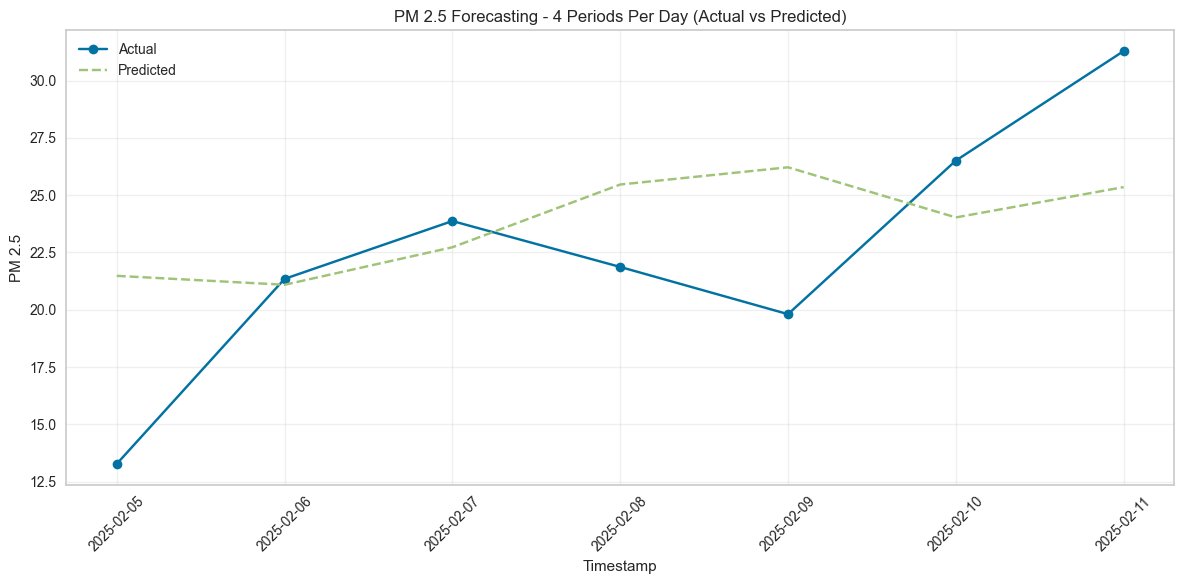

In [42]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# คำนวณค่า SMAPE โดยใช้ mean_absolute_percentage_error


predictions2 = predict_model(final_et, data=test)
predictions2 = predictions2["prediction_label"]
# Evaluate Performance
mae = mean_absolute_error(test["pm_2_5"], predictions2)
mse = mean_squared_error(test["pm_2_5"], predictions2)
mape = mean_absolute_percentage_error(test["pm_2_5"], predictions2) * 100
# คำนวณ SMAPE ตามสูตรจริง
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# คำนวณค่า SMAPE
smape = smape(test["pm_2_5"].values, predictions2.values)

r2 = r2_score(test["pm_2_5"], predictions2)
accurent = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")
print(f"R2: {r2:.2f}")
print(f"accurent: {accurent:.2f}")

# ✅ แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
plt.figure(figsize=(12, 6))
plt.plot(
    test["pm_2_5"].index.to_timestamp(), test["pm_2_5"], label="Actual", marker="o"
)
plt.plot(
    test["pm_2_5"].index.to_timestamp(),
    predictions2,
    label="Predicted",
    linestyle="--",
    marker="x",
)
plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5")
plt.legend()
plt.grid(True, alpha=0.3)

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

MAE: 4.24
MSE: 25.43
MAPE: 19.50%
SMAPE: 20.61%
R2: 0.06
accurent: 80.50


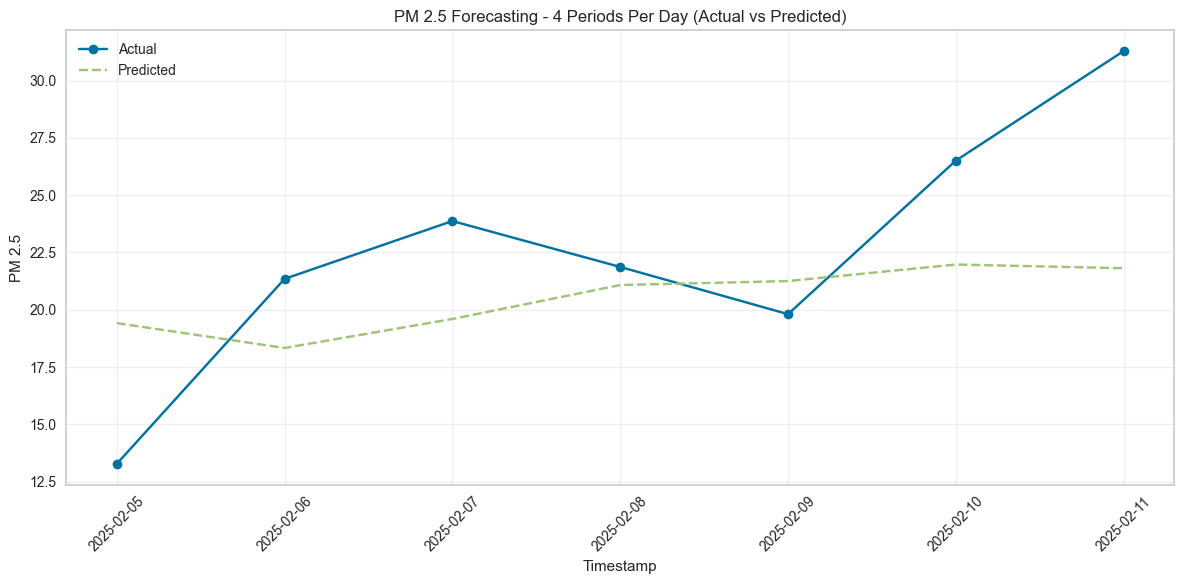

In [33]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# คำนวณค่า SMAPE โดยใช้ mean_absolute_percentage_error


predictions = predict_model(final_arima, X=X_forecast)

# Evaluate Performance
mae = mean_absolute_error(test["pm_2_5"], predictions)
mse = mean_squared_error(test["pm_2_5"], predictions)
mape = mean_absolute_percentage_error(test["pm_2_5"], predictions) * 100
# คำนวณ SMAPE ตามสูตรจริง
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# คำนวณค่า SMAPE
smape = smape(test["pm_2_5"].values, predictions.values)

r2 = r2_score(test["pm_2_5"], predictions)
accurent = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")
print(f"R2: {r2:.2f}")
print(f"accurent: {accurent:.2f}")

# ✅ แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
plt.figure(figsize=(12, 6))
plt.plot(
    test["pm_2_5"].index.to_timestamp(), test["pm_2_5"], label="Actual", marker="o"
)
plt.plot(
    test["pm_2_5"].index.to_timestamp(),
    predictions,
    label="Predicted",
    linestyle="--",
    marker="x",
)
plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5")
plt.legend()
plt.grid(True, alpha=0.3)

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

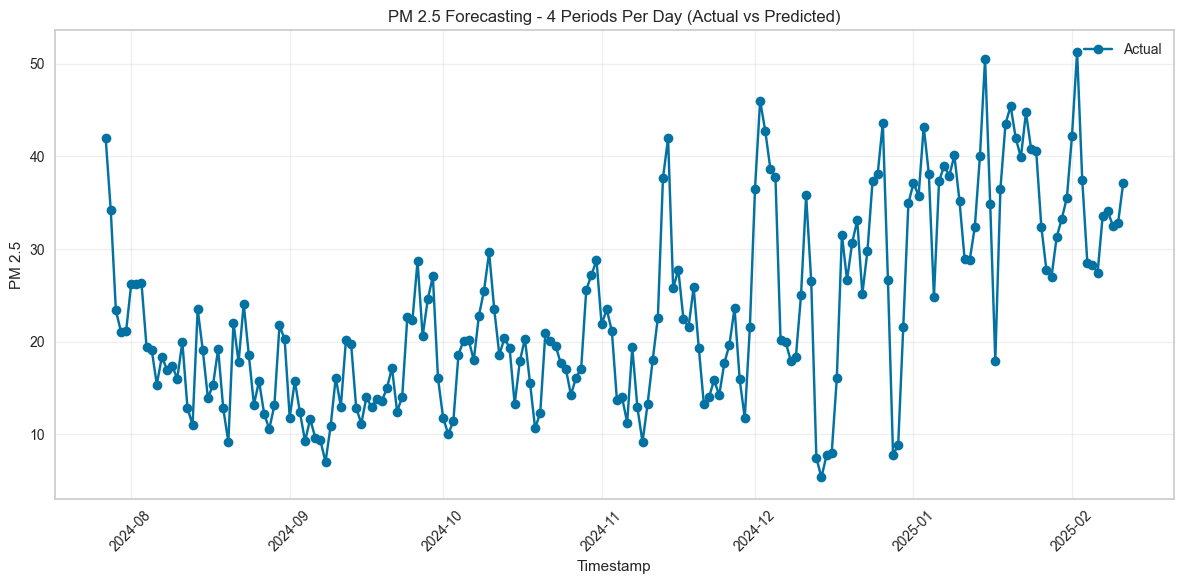

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(
    df["pm_2_5"][-200:].index, df["pm_2_5"][-200:], label="Actual", marker="o"
)


plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5")
plt.legend()
plt.grid(True, alpha=0.3)

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [39]:
predictions = predictions["y_pred"]

KeyError: "Cannot interpret 'y_pred' as period"

In [40]:
predictions2

,pm_2_5_lag8,humidity_lag8,temperature_lag8,pm_2_5_lag10,humidity_lag10,temperature_lag10,pm_2_5_lag14,humidity_lag14,temperature_lag14,pm_2_5_lag21,...,temperature_rollmean7,temperature_rollstd7,pm_2_5_rollmean14,pm_2_5_rollstd14,humidity_rollmean14,humidity_rollstd14,temperature_rollmean14,temperature_rollstd14,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-05,13.836335,77.732895,27.597878,17.906115,85.964218,27.642649,34.378857,79.693504,27.840408,42.659870,...,27.568386,0.545626,20.352505,9.672557,84.279343,5.060097,27.252916,0.739385,13.278379,21.480473
2025-02-06,17.949482,76.719330,27.252470,13.610323,80.983757,27.830048,35.483215,82.923149,27.559990,7.676393,...,27.477285,0.597986,21.062054,9.013014,83.240631,5.737275,27.241072,0.743545,21.348629,21.091117
2025-02-07,17.610088,73.220795,26.922285,13.836335,77.732895,27.597878,13.679726,91.635094,26.650429,4.879026,...,27.446581,0.650712,22.657246,7.826732,82.483047,6.000811,27.200682,0.772390,23.870686,22.727645
2025-02-08,27.211723,75.662956,26.435497,17.949482,76.719330,27.252470,25.060976,82.680931,28.445240,21.882992,...,27.195625,0.528677,23.564178,8.441603,81.492302,5.594462,27.285889,0.620741,21.868439,25.463356
2025-02-09,34.580032,77.260460,26.688551,17.610088,73.220795,26.922285,17.906115,85.964218,27.642649,35.077911,...,27.041727,0.533636,23.585342,8.473002,80.367638,4.758135,27.307110,0.587459,19.808958,26.215641
2025-02-10,35.374210,76.631607,26.565365,27.211723,75.662956,26.435497,13.610323,80.983757,27.830048,22.454197,...,26.848894,0.436303,23.792553,8.478682,80.175209,4.768117,27.226088,0.619166,26.507221,24.028567
2025-02-11,25.355150,78.695007,26.480207,34.580032,77.260460,26.688551,13.836335,77.732895,27.597878,21.059505,...,26.871597,0.483369,23.383057,8.754782,79.898529,4.725708,27.261988,0.635283,31.285423,25.350872


In [ ]:
final_arima

ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('model',
                                                                ARIMA(order=(1,
                                                                             0,
                                                                             1),
                                                                      seasonal_order=(0,
                                                                                      0,
                                                                                      1,
                                                                                      7)))]))])

2025-02-05    20.449137
2025-02-06    19.712858
2025-02-07    21.163273
2025-02-08    23.271328
2025-02-09    23.734770
2025-02-10    23.001384
2025-02-11    23.581486
Freq: D, dtype: float64
MAE: 4.01
MSE: 21.49
MAPE: 19.58%
SMAPE: 18.43%
R2: 0.20
accurent: 80.42


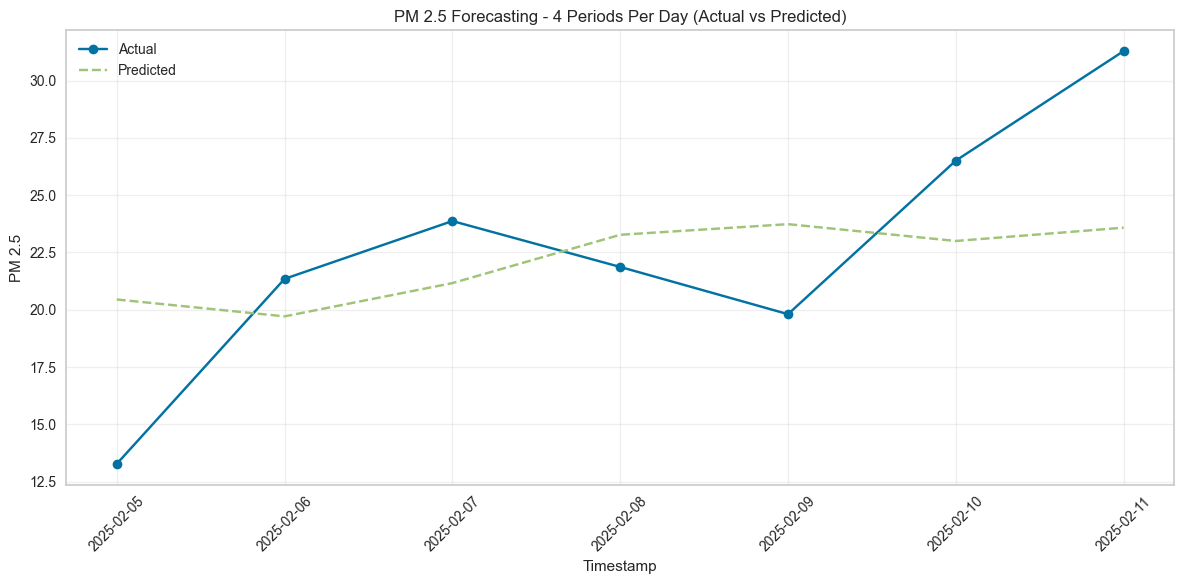

In [43]:
final_forecast = (predictions + predictions2) / 2
print(final_forecast )
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt




# Evaluate Performance
mae = mean_absolute_error(test["pm_2_5"], final_forecast)
mse = mean_squared_error(test["pm_2_5"], final_forecast)
mape = mean_absolute_percentage_error(test["pm_2_5"], final_forecast) * 100
# คำนวณ SMAPE ตามสูตรจริง
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# คำนวณค่า SMAPE
smape = smape(test["pm_2_5"].values, final_forecast.values)

r2 = r2_score(test["pm_2_5"], final_forecast)
accurent = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")
print(f"R2: {r2:.2f}")
print(f"accurent: {accurent:.2f}")

# ✅ แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
plt.figure(figsize=(12, 6))
plt.plot(
    test["pm_2_5"].index.to_timestamp(), test["pm_2_5"], label="Actual", marker="o"
)
plt.plot(
    test["pm_2_5"].index.to_timestamp(),
    final_forecast,
    label="Predicted",
    linestyle="--",
    marker="x",
)
plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5")
plt.legend()
plt.grid(True, alpha=0.3)

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
final_forecast = (predictions + predictions2) / 2
print(final_forecast )
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt




# Evaluate Performance
mae = mean_absolute_error(test["pm_2_5"], final_forecast)
mse = mean_squared_error(test["pm_2_5"], final_forecast)
mape = mean_absolute_percentage_error(test["pm_2_5"], final_forecast) * 100
# คำนวณ SMAPE ตามสูตรจริง
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# คำนวณค่า SMAPE
smape = smape(test["pm_2_5"].values, final_forecast.values)

r2 = r2_score(test["pm_2_5"], final_forecast)
accurent = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")
print(f"R2: {r2:.2f}")
print(f"accurent: {accurent:.2f}")

# ✅ แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
plt.figure(figsize=(12, 6))
plt.plot(
    test["pm_2_5"].index.to_timestamp(), test["pm_2_5"], label="Actual", marker="o"
)
plt.plot(
    test["pm_2_5"].index.to_timestamp(),
    final_forecast,
    label="Predicted",
    linestyle="--",
    marker="x",
)
plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5")
plt.legend()
plt.grid(True, alpha=0.3)

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'predictions' is not defined

In [5]:
save_model(final_arima,"hourly_csv\export-jsps016-1h")
save_model(final_et,"hourly_csv\export-jsps016-1hre")

Transformation Pipeline and Model Successfully Saved


NameError: name 'final_et' is not defined